In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import sys
sys.path.append(os.environ['GORDON_REPO_DIR'] + '/pipeline_scripts')

import utilities2014
reload(utilities2014)
from utilities2014 import *

In [3]:
import time

sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import average, fcluster, leaders, complete, single, dendrogram, ward

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.util import img_as_float, pad
from skimage.morphology import disk
from skimage.filters.rank import gradient

from collections import defaultdict, Counter
from itertools import combinations, chain, product

import networkx
from networkx import from_dict_of_lists, dfs_postorder_nodes

import matplotlib.pyplot as plt
%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


In [ ]:
# def compute_overlap(c1, c2):
#     return float(len(c1 & c2)) / min(len(c1),len(c2))

# def compute_overlap2(c1, c2):
#     return float(len(c1 & c2)) / len(c1 | c2)    

# def compute_overlap_partial(indices, sets, metric='jaccard'):
#     n_sets = len(sets)
    
#     overlap_matrix = np.zeros((len(indices), n_sets))
        
#     for ii, i in enumerate(indices):
#         for j in range(n_sets):
#             c1 = set(sets[i])
#             c2 = set(sets[j])
#             if len(c1) == 0 or len(c2) == 0:
#                 overlap_matrix[ii, j] = 0
#             else:
#                 if metric == 'min-jaccard':
#                     overlap_matrix[ii, j] = compute_overlap(c1, c2)
#                 elif metric == 'jaccard':
#                     overlap_matrix[ii, j] = compute_overlap2(c1, c2)
#                 else:
#                     raise Exception('metric %s is unknown'%metric)
            
#     return overlap_matrix

# def compute_pairwise_distances(sets, metric):

#     partial_overlap_mat = Parallel(n_jobs=16, max_nbytes=1e6)(delayed(compute_overlap_partial)(s, sets, metric=metric) 
#                                         for s in np.array_split(range(len(sets)), 16))
#     overlap_matrix = np.vstack(partial_overlap_mat)
#     distance_matrix = 1 - overlap_matrix
    
#     np.fill_diagonal(distance_matrix, 0)
    
#     return distance_matrix


# def group_clusters(clusters=None, dist_thresh = 0.1, distance_matrix=None, metric='jaccard', linkage='complete'):
    
#     if distance_matrix is not None:
#         keys = range(len(distance_matrix))
#         if clusters is not None:
#             values = clusters
#         else:
#             values = range(len(distance_matrix))
#     else:
#         if isinstance(clusters, dict):
#             keys = clusters.keys()
#             values = clusters.values()
#         elif isinstance(clusters, list):
#             if isinstance(clusters[0], tuple):
#                 keys = [i for i,j in clusters]
#                 values = [j for i,j in clusters]
#             else:
#                 keys = range(len(clusters))
#                 values = clusters
#         else:
#             raise Exception('clusters is not the right type')
    
#     if clusters is None:
#         assert distance_matrix is not None, 'distance_matrix must be provided.'
    
#     if distance_matrix is None:
#         assert clusters is not None, 'clusters must be provided'
#         distance_matrix = compute_pairwise_distances(values, metric)
        
#     if linkage=='complete':
#         lk = complete(squareform(distance_matrix))
#     elif linkage=='average':
#         lk = average(squareform(distance_matrix))
#     elif linkage=='single':
#         lk = single(squareform(distance_matrix))

#     # T = fcluster(lk, 1.15, criterion='inconsistent')
#     T = fcluster(lk, dist_thresh, criterion='distance')
    
#     n_groups = len(set(T))
#     groups = [None] * n_groups

#     for group_id in range(n_groups):
#         groups[group_id] = np.where(T == group_id+1)[0]

#     index_groups = [[keys[i] for i in g] for g in groups if len(g) > 0]
#     res = [[values[i] for i in g] for g in groups if len(g) > 0]
        
#     return index_groups, res, distance_matrix


In [4]:
# def detect_open_boundaries(sec_ind):
    
dm = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=2)
dm._load_image()

# Load image and relevant data
# im_height, im_width = dm.[:2]

texton_hists = dm.load_pipeline_result('texHist', 'npy')
segmentation = dm.load_pipeline_result('segmentation', 'npy')
n_superpixels = len(np.unique(segmentation)) - 1
textonmap = dm.load_pipeline_result('texMap', 'npy')
n_texton = len(np.unique(textonmap)) - 1
neighbors = dm.load_pipeline_result('neighbors', 'pkl')
sp_properties = dm.load_pipeline_result('spProps', 'npy')
segmentation_vis = dm.load_pipeline_result('segmentationWithText', 'jpg')

# Load region proposals
expansion_clusters_tuples = dm.load_pipeline_result('clusters', 'pkl')
expansion_clusters, expansion_cluster_scores = zip(*expansion_clusters_tuples)
expansion_cluster_scores = np.array(expansion_cluster_scores)

neighbors_dict = dict(zip(np.arange(n_superpixels), [list(i) for i in neighbors]))
neighbor_graph = from_dict_of_lists(neighbors_dict)

surrounds_sps = dm.load_pipeline_result('clusterSurrounds', 'pkl')
frontiers_sps = dm.load_pipeline_result('clusterFrontiers', 'pkl')

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [5]:
Gmax = np.load('/home/yuncong/csd395/Gmax.npy')

In [7]:
# votes for directed edgelets
dedge_vote_dict = defaultdict(float)

# Compute the supporter sets of every edgelet, based on region proposals
# supporter_all[(100,101)] is the set of superpixels that supports directed edgelet (100,101)
dedge_supporters = defaultdict(list)

for s in range(n_superpixels):
#     if s not in sps_in_good_regions: continue

    c = list(expansion_clusters[s])
    interior_texture = texton_hists[c].mean(axis=0)
    b_sps = surrounds_sps[s]
    b_contrasts = cdist(texton_hists[b_sps], interior_texture[np.newaxis, :], chi2)

    for b_sp, b_contrast in zip(b_sps, b_contrasts):
        int_sps = neighbors[b_sp] & set(expansion_clusters[s])
        for int_sp in int_sps:
            # weight of each edgelet is the contrast normalized by region size
#             weight = float(b_contrast) / max(len(c), 5)
#             weight = 1. / max(len(c), 5)
            weight = 1.
            dedge_vote_dict[(b_sp, int_sp)] += weight
#             dedge_vote_dict[(int_sp, b_sp)] += weight
            dedge_supporters[(b_sp, int_sp)].append(s) # (border_sp, interior_sp) or (out, in)

dedge_vote_dict.default_factory = None
dedge_supporters.default_factory = None

In [8]:
edge_coords = dict(dm.load_pipeline_result('edgeCoords', 'pkl'))
all_edges = edge_coords.keys()
all_dedges = set(chain(*[[(i,j),(j,i)] for i,j in all_edges]))

edge_neighbors = dm.load_pipeline_result('edgeNeighbors', 'pkl')

In [9]:
def visualize_edge_weights_by_transparency(vote_dict, vmin, bg=None):
    
    img_edge = np.zeros_like(dm.image_rgb, np.float)
    img_edge_alpha = np.zeros_like(dm.image, np.float)
    for edge, s in vote_dict.iteritems():
        if s > vmin:
            cs = edge_coords[frozenset(edge)]
            img_edge[cs[:,1], cs[:,0]] = (1.,0,0)
            img_edge_alpha[cs[:,1], cs[:,0]] = s

    img_edge_alpha = (img_edge_alpha-img_edge_alpha.min())/(img_edge_alpha.max()-img_edge_alpha.min())
    
    if bg is not None:
        img_highvote = alpha_blending(img_as_float(bg), img_edge, .2, .8 * img_edge_alpha)
        img_highvote[~dm.mask] = 0.
        return img_highvote
    else:
        return img_edge_alpha

In [10]:
# dedge_vote_thresh = np.sort(dedge_vote_dict.values())[-.2*len(dedge_vote_dict)]
# print dedge_vote_thresh

# display(visualize_dedge_vote(dedge_vote_dict, bg=True, vote_thresh=dedge_vote_thresh))

In [11]:
sp_contained_by = [[] for _ in range(n_superpixels)]
for sp_ind, cl in enumerate(expansion_clusters):
    for s in cl:
        sp_contained_by[s].append(sp_ind)
        
sp_edges = [[(n,s) for n in neighbors[s]] for s in range(n_superpixels)]

edge_contained_by = defaultdict(set)

for s in range(n_superpixels):
    for de in sp_edges[s]:
        edge_contained_by[de] |= set(sp_contained_by[s])
        
edge_contained_by.default_factory = None

assert set.issubset(set(edge_contained_by.keys()), all_dedges), 'extraneous edges'


In [12]:
# all_edges = edge_coords.keys()
# all_dedges = set(chain(*[[(i,j),(j,i)] for i,j in all_edges]))

# try:
#     raise
#     edge_contained_by = dm.load_pipeline_result('edgeContainedBy', 'pkl')
#     print "edgeContainedBy.pkl already exists, skip"

# except:
#     cluster_edges = dm.load_pipeline_result('clusterEdges', 'pkl')

#     def f(c, e):
#         q = set(chain(*[[(i,j),(j,i)] for i,j in combinations(c, 2) if frozenset([i,j]) in all_edges]))
#         return q | set(e)

#     contain_edges = Parallel(n_jobs=16)(delayed(f)(c,e) for c, e in zip(expansion_clusters, cluster_edges))

#     edge_contained_by = defaultdict(set)
#     for sp, es in enumerate(contain_edges):
#         for e in es:
#             edge_contained_by[e].add(sp)

#     edge_contained_by.default_factory = None

#     dm.save_pipeline_result(edge_contained_by, 'edgeContainedBy', 'pkl')  


In [12]:
nz_dedges = dedge_vote_dict.keys()

In [13]:
# dedge_contrast = dict([((i,j), chi2(texton_hists[i], texton_hists[j])) for i,j in all_dedges])
dedge_contrast = dict([((i,j), chi2(texton_hists[i], texton_hists[dedge_supporters[(i,j)]].mean(axis=0))) 
                       for i,j in nz_dedges])

In [14]:
# edges_contained_by_one_sp = [e for e, sps in edge_contained_by.iteritems() if len(sps) == 1]

In [15]:
# set(edges_contained_by_one_sp) & set(nz_dedges2)

In [16]:
nz_dedges2 = [e for e,sps in edge_contained_by.iteritems() if len(sps) > 0 and e in nz_dedges]
nz_dedges2 = [e for e in nz_dedges2 if dedge_contrast[e] > .5]

# nz_dedges2 = [e for e, sps in edge_contained_by.iteritems() if e in nz_dedges]
dedge_stopperness = dict([(e, dedge_vote_dict[e]/len(edge_contained_by[e])) for e in nz_dedges2])
# dedge_stopperness = dict([(e, dedge_vote_dict[e]/len(edge_contained_by[e])) for e in nz_dedges])

In [17]:
nz_dedges2 = [e for e in nz_dedges2 if dedge_stopperness[e] == 1]
print len(nz_dedges2), 'valid edges'

4399 valid edges


In [19]:
display(visualize_edge_weights_by_transparency(dedge_contrast, bg=dm.image_rgb, vmin=.5), 'contrast.jpg')

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/contrast.jpg

In [18]:
stopratio_viz = visualize_edge_weights_by_transparency(dedge_stopperness, bg=dm.image_rgb, vmin=.99)
# display(stopratio_viz, 'stopperness.jpg')

In [279]:
# Method 1

In [49]:
def smart_union(x):
    cc = Counter(chain(*x))
    gs = set([s for s, c in cc.iteritems() if c > (cc.most_common(1)[0][1]*.3)])                           
    return gs

In [50]:
dedge_expandedSupporters = dict([(e, smart_union([expansion_clusters[s] for s in dedge_supporters[e]])) 
                                 for e in nz_dedges2])

dedges_grouped, dedge_supporters_grouped, _ = group_clusters(clusters=dict((e, dedge_expandedSupporters[e]) for e in nz_dedges2),
                                                             dist_thresh=.01, linkage='complete', metric='jaccard')

print len(dedges_grouped), 'edge groups'

847 edge groups


In [ ]:
dedge_group_supporters = map(smart_union, dedge_supporters_grouped)
dedge_group_supporter_distmat = compute_pairwise_distances(dedge_group_supporters, metric='jaccard')

In [52]:
# dedge_group_supporter_distmat = dedge_group_supporter_distmat > .1
np.fill_diagonal(dedge_group_supporter_distmat, 0)

# plt.matshow(dedge_group_supporter_distmat);
# plt.colorbar();

In [6]:
dedge_vectors = dm.load_pipeline_result('edgeVectors', 'pkl')
dedge_neighbors = dm.load_pipeline_result('dedgeNeighbors', 'pkl')

In [21]:
# vector_map = np.nan * np.ones((dm.image_height, dm.image_width, 2, 2))
# # stopratio_map = np.zeros((dm.image_height, dm.image_width, 2))
# # contrast_map = np.zeros((dm.image_height, dm.image_width))
# int_texture_map = np.nan * np.ones((dm.image_height, dm.image_width, 2, n_texton))
# ext_texture_map = np.nan * np.ones((dm.image_height, dm.image_width, 2, n_texton))

# edge_map = np.zeros((dm.image_height, dm.image_width), dtype=np.bool)

# for e in all_edges:
#     pts = edge_coords[e]
#     i,j = e
#     vector_map[pts[:,1], pts[:,0], 0] = dedge_vectors[(i,j)]
#     stopratio_map[pts[:,1], pts[:,0], 0] = dedge_stopperness[(i,j)] if (i,j) in dedge_stopperness else 0
    
#     vector_map[pts[:,1], pts[:,0], 1] = dedge_vectors[(j,i)]
#     stopratio_map[pts[:,1], pts[:,0], 1] = dedge_stopperness[(j,i)] if (j,i) in dedge_stopperness else 0
    
#     contrast_map[pts[:,1], pts[:,0]] = max(dedge_contrast[(i,j)] if (i,j) in dedge_contrast else 0,
#                                            dedge_contrast[(j,i)] if (j,i) in dedge_contrast else 0)
    
#     int_texture_map[pts[:,1], pts[:,0], 0] = texton_hists[j]
#     ext_texture_map[pts[:,1], pts[:,0], 0] = texton_hists[i]
#     int_texture_map[pts[:,1], pts[:,0], 1] = texton_hists[i]
#     ext_texture_map[pts[:,1], pts[:,0], 1] = texton_hists[j]
    
#     edge_map[pts[:,1], pts[:,0]] = 1

In [7]:
def chi2s(h1s, h2s):
    '''
    h1s is n x n_texton
    '''
    s = (h1s+h2s).astype(np.float)
    ss = (h1s-h2s)**2/s
    ss[s==0] = 0
    return np.sum(ss, axis=1)

In [6]:
segment_points = np.load('/home/yuncong/csd395/sample_landmark_2.npy')
sample_segment_int_texture = segment_points[:, 2:2+n_texton]
sample_segment_ext_texture = segment_points[:, 2+n_texton:-2]

sample_segment_vector = segment_points[:, -2:]

In [8]:
template_points_rotated_versions = []

centroid = np.mean(segment_points[:, [1,0]], axis=0)
segment_points_centered = segment_points[:, [1,0]] - centroid

thetas = np.linspace(-np.pi/4, np.pi/4, 9)

for theta in thetas:
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    sample_segment_pts = np.dot(R, segment_points_centered.T).astype(np.int).T
    shifted_sample_segment_pts = sample_segment_pts - sample_segment_pts.min(axis=0)
    
    template_points_rotated_versions.append(shifted_sample_segment_pts)
    
template_shape_rotated_versions = [pts.max(axis=0) + [1,1] for pts in template_points_rotated_versions]

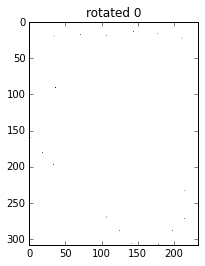

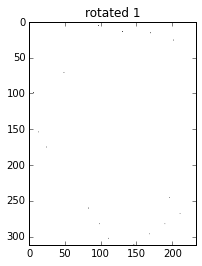

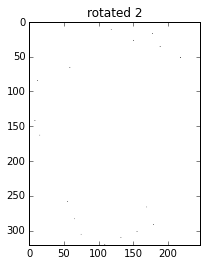

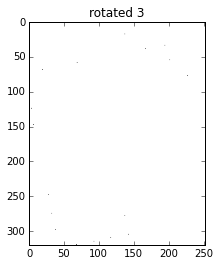

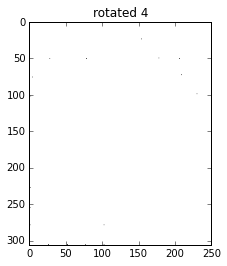

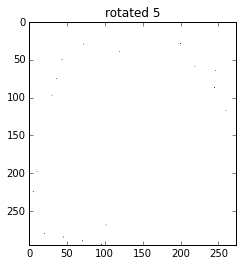

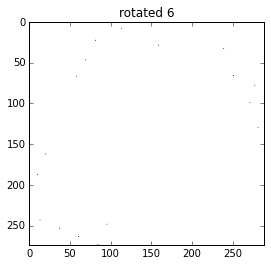

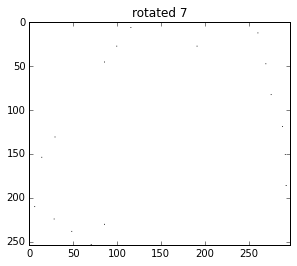

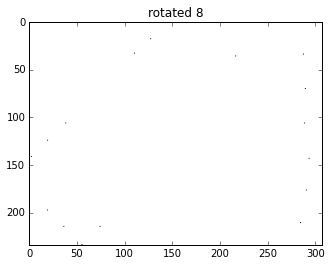

In [192]:
# visualize the templates

for i in range(len(thetas)):

    template_points = template_points_rotated_versions[i]
    
    template = np.zeros(template_shape_rotated_versions[i], np.bool)
    template[template_points[:,0], template_points[:,1]] = 1
    plt.figure()
    plt.title('rotated %d' % i)
    plt.imshow(template, cmap=plt.cm.gray_r)

In [48]:
# yy = shifted_ys_best
# xx = shifted_xs_best

# # valid = edge_map[yy, xx]
# # yy = yy[valid]
# # xx = xx[valid]

# # q = np.sum(sample_segment_vector[valid] * vector_map[yy, xx, 0], axis=1)
# # valid2 = np.abs(q) > .5

# # q = q[valid2]
# # yy = yy[valid2]
# # xx = xx[valid2]
# # valid = valid[valid2]

In [11]:
texture_map = texton_hists[segmentation]
texture_map[~dm.mask] = np.nan * np.ones((n_texton,))
dm.save_pipeline_result(texture_map, 'textureMap', 'npy')

saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0002/RS141_x5_0002_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_textureMap.npy


In [9]:
texture_map = dm.load_pipeline_result('textureMap', 'npy')

In [13]:
viz = plt.cm.Accent(texture_map[...,0]/np.nanmax(texture_map[...,0]))
display(viz)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [75]:
# ys = yy[:,None] + int_texture_sampling_positions[:,:,0]
# xs = xx[:,None] + int_texture_sampling_positions[:,:,1]
# avg_int_texture = texture_map[ys, xs].mean(axis=1)

In [76]:
# chi2s(sample_segment_int_texture, avg_int_texture)

array([ 0.42128261,  0.42128261,  0.46858489, ...,  0.82985645,
        0.73044868,  0.7817039 ])

In [14]:
r = np.linspace(0,1,6) * 20
ext_texture_sampling_positions = (sample_segment_vector[:, None, ::-1] * r[None,:,None]).astype(np.int)
int_texture_sampling_positions = (sample_segment_vector[:, None, ::-1] * -r[None,:,None]).astype(np.int)

In [15]:
def f(s, template_pts):
    vs = np.empty((len(s),), dtype=np.float)
    ss = []
    for i, (x, y) in enumerate(s):
        yy = y + template_pts[:,0]
        xx = x + template_pts[:,1]
        
        r = Gmax[yy, xx]
        
        ys = np.maximum(np.minimum(yy[:,None] + int_texture_sampling_positions[:,:,0], dm.image_height-1), 0)
        xs = np.maximum(np.minimum(xx[:,None] + int_texture_sampling_positions[:,:,1], dm.image_width-1), 0)
        avg_int_texture = np.nanmean(texture_map[ys, xs], axis=1)
        cs_int = chi2s(sample_segment_int_texture, avg_int_texture)
    
        ys = np.maximum(np.minimum(yy[:,None] + ext_texture_sampling_positions[:,:,0], dm.image_height-1), 0)
        xs = np.maximum(np.minimum(xx[:,None] + ext_texture_sampling_positions[:,:,1], dm.image_width-1), 0)
        avg_ext_texture = np.nanmean(texture_map[ys, xs], axis=1)
        cs_ext = chi2s(sample_segment_ext_texture, avg_ext_texture)
        
        v = np.nansum(r * (np.exp(-cs_int/.5) + np.exp(-cs_ext/.5)))
        ss.append(np.c_[r, cs_int, cs_ext])
        vs[i] = v
        
#         v = np.sum(r)
#         vs[i] = v
#         ss.append(None)
        
    return vs, ss

In [ ]:
template_points_rotated_versions[theta]

In [ ]:
ret = Parallel(n_jobs=16)(delayed(f)(s, template_points_rotated_versions[theta]) 
                        for s in np.array_split(zip(xs.flat, ys.flat), 2))

In [16]:
b = time.time()

theta = 4
grid_spacing = (10,10)

template_height, template_width = template_shape_rotated_versions[theta]
ys, xs = np.mgrid[:dm.image_height - template_height:grid_spacing[0], 
                  :dm.image_width - template_width:grid_spacing[1]]

ret = []
for s in np.array_split(zip(xs.flat, ys.flat), 16):
    ret.append(f(s, template_points_rotated_versions[theta]))

# ret = Parallel(n_jobs=16)(delayed(f)(s, template_points_rotated_versions[theta]) 
#                         for s in np.array_split(zip(xs.flat, ys.flat), 16))

V, ss = zip(*ret)
vs = np.concatenate(V)
sss = list(chain(*ss))

vss = np.reshape(vs, xs.shape)

# V = Parallel(n_jobs=16)(delayed(f)(s, template_points_rotated_versions[theta]) 
#                         for s in np.array_split(zip(xs.flat, ys.flat), 16))
# vs = np.concatenate(V)

print time.time() - b

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


60.6035768986


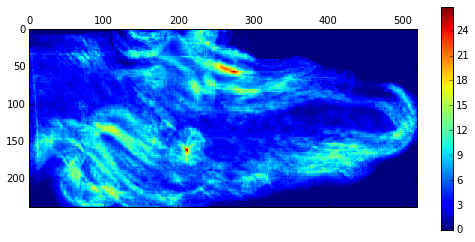

In [17]:
plt.matshow(vss);
plt.colorbar();

In [19]:
from skimage.feature import peak_local_max

peaks = peak_local_max(vss)
ypeaks = peaks[:,0]
xpeaks = peaks[:,1]

order = np.argsort(vss[ypeaks, xpeaks])[::-1]
ypeaks = ypeaks[order]
xpeaks = xpeaks[order]

In [20]:
# plt.imshow(Gmax/Gmax.max());
# plt.axis('off');

# # display(Gmax/Gmax.max())

In [21]:
pos_sorted = vss.flatten().argsort()

bg_ubyte = img_as_ubyte(dm.image_rgb)

# for i in range(1, 100):

# ybest, xbest = np.unravel_index(12558, vss.shape)
# ybest, xbest = np.unravel_index(72917, vss.shape)
# ybest, xbest = np.unravel_index(80658, vss.shape)

# ybest = 160
# xbest = 95

for i, (ybest, xbest) in enumerate(zip(ypeaks, xpeaks)[:3]):
    #     ybest, xbest = np.unravel_index(pos_sorted[-i], vss.shape)
    print ybest, xbest, vss[ybest, xbest]
    # ybest, xbest = np.unravel_index(vss.argmax(), vss.shape)

    shifted_ys_best = ys[ybest, xbest] + template_points_rotated_versions[theta][:,0]
    shifted_xs_best = xs[ybest, xbest] + template_points_rotated_versions[theta][:,1]
    
    overlay = np.zeros_like(dm.image, np.bool)
    overlay[shifted_ys_best, shifted_xs_best] = 1
    overlay = binary_dilation(overlay, disk(5))
    bg_ubyte[overlay] = [0,255,0]

    cv2.putText(bg_ubyte, str(i), (xs[ybest, xbest], ys[ybest, xbest]), 
                cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 3, ((255,0,255)), 10)

display(bg_ubyte)

162 211 26.9007650457
58 274 26.3061239421
213 86 19.7797554291


/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [398]:
def snap(pts, contrast_map):
    n = len(pts)

    D = cdist(pts, pts)
    pts_sorted = D.argsort(axis=1)[:,:20]

    gradient_dirs = np.empty((pts.shape[0], 2))
    for i, neighborhood in enumerate(pts_sorted):
        X = pts[neighborhood]
        c = X.mean(axis=0)
        Xc = X - c
        U,S,V = np.linalg.svd(np.dot(Xc.T, Xc))
        gradient_dir = U[:,0]
        gradient_dirs[i] = gradient_dir

    snap_explore_radius = 50
    rs = np.arange(-snap_explore_radius, snap_explore_radius)
    sample_ys = pts[:,0][:,None] + np.outer(gradient_dirs[:,0], rs).astype(np.int)
    sample_xs = pts[:,1][:,None] + np.outer(gradient_dirs[:,1], rs).astype(np.int)
    best_sample = contrast_map[sample_ys, sample_xs].argmax(axis=1)
    snapped_pts = np.c_[sample_ys[range(n), best_sample], sample_xs[range(n), best_sample]]
    
    return snapped_pts

In [392]:
snapped

array([[1123, 4603],
       [1124, 4602],
       [1124, 4602],
       ..., 
       [1671, 4897],
       [1671, 4897],
       [2185, 4923]])

In [399]:
snapped = np.c_[shifted_ys_best, shifted_xs_best]

for i in range(100):
    
    snapped_new = snap(snapped, contrast_map)

    print np.sum(np.abs(snapped - snapped_new))
    if np.sum(np.abs(snapped - snapped_new)) < 100:
        break
    snapped = snapped_new

177395
133701
70959
27719
15716
10332
6405
3887
1326
503
279
186
188
185


KeyboardInterrupt: 

In [396]:
from skimage.morphology import disk

In [400]:
# bg = stopratio_viz[:,:,:3].copy()
bg = dm.image_rgb.copy()

overlay = np.zeros_like(dm.image, np.bool)
overlay[snapped[:,0], snapped[:,1]] = 1
overlay = binary_dilation(overlay, disk(5))

bg[overlay] = [0,1,0]

display(bg)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [311]:
viz = plt.cm.jet(contrast_map/contrast_map.max());
display(viz)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [576]:
display(vss/vss.max())

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [38]:
import networkx

In [39]:
G = networkx.from_dict_of_lists(dedge_neighbors)

In [40]:
# edge junction as nodes
Gs = networkx.Graph()
for u,v,d in G.edges(data=True):
    if u in dedge_contrast and v in dedge_contrast:
        c = .5 * dedge_contrast[u] + .5 * dedge_contrast[v]
        w = np.exp(-c)
    else:
        w = np.inf
    Gs.add_edge(u,v, {'weight':w})

In [41]:
# for p in nx.all_shortest_paths(G, (687,784), (1963,1865)):
p = networkx.shortest_path(Gs, (687,784), (1880,1796), 'weight')

In [42]:
display(dm.visualize_edge_sets([p]))

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [43]:
segment_points = np.vstack([np.r_[pt, texton_hists[e[0]], texton_hists[e[1]], dedge_vectors[e]] for e in p for pt in edge_coords[frozenset(e)]])

In [44]:
np.save('/home/yuncong/csd395/sample_segment.npy', segment_points)

In [82]:
dedges_grouped = map(set, dedges_grouped)
ngroup = len(dedges_grouped)

conns = [[set() if any([sorted(e1)==sorted(e2) for e1, e2 in product(eg1, eg2)]) 
          else set([(i,j) for i,j in G.edges(eg1|eg2) if (i in eg1 and j in eg2) or (j in eg1 and i in eg2)]) 
         for eg1 in dedges_grouped] for eg2 in dedges_grouped]
conns_flat = [a for b in conns for a in b ]

In [97]:
dedge_group_supporter_distmat[259][367]

1.0

In [115]:
dedge_group_supporterTex_distmat = np.reshape([chi2(texton_hists[list(sps1)].mean(axis=0), texton_hists[list(sps2)].mean(axis=0))  
 for sps1, sps2 in product(dedge_group_supporters, dedge_group_supporters)], (ngroup, ngroup))

In [ ]:
# dedge_group_supporterTex_distmat = np.reshape([cdist(texton_hists[list(sps1)], texton_hists[list(sps2)], metric=chi2).mean() 
#                                                for sps1, sps2 in product(dedge_group_supporters, dedge_group_supporters)], 
#                                               (ngroup, ngroup))

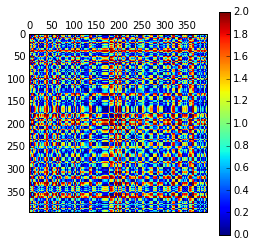

In [118]:
plt.matshow(dedge_group_supporterTex_distmat);
plt.colorbar();

In [122]:
w

[259, 262, 365, 366, 367, 368]

<matplotlib.colorbar.Colorbar instance at 0x1248e5a8>

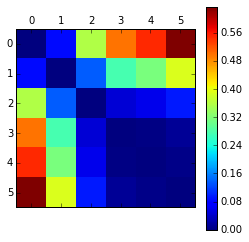

In [127]:
plt.matshow(dedge_group_supporterTex_distmat[w][:,w]);
plt.colorbar()

In [83]:
dedge_group_edgeConn_distmat = np.reshape(map(lambda x: len(x) < 1, conns_flat), (ngroup, ngroup))
np.fill_diagonal(dedge_group_edgeConn_distmat, 0)

# plt.matshow(dedge_group_edgeConn_distmat);
# plt.colorbar();

In [128]:
dedge_group_distmat = 1 - (1-dedge_group_edgeConn_distmat) * (1-dedge_group_supporter_distmat > 0.1) * (dedge_group_supporterTex_distmat < .25)

In [101]:
w = [259, 262, 365, 366, 367, 368]

In [102]:
dedge_group_distmat[w][:,w]

array([[0, 0, 1, 1, 1, 1],
       [0, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0],
       [1, 1, 0, 1, 0, 0],
       [1, 1, 1, 0, 0, 0]])

In [126]:
display(dm.visualize_edges_and_superpixels([dedges_grouped[367]], 
                                           [dedge_group_supporters[367]]))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [107]:
display(dm.visualize_edges_and_superpixels([dedges_grouped[i] for i in w], [dedge_group_supporters[i] for i in w]))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [129]:
ig, edge_groups2, _ = group_clusters(clusters=dedges_grouped, 
                                   distance_matrix=dedge_group_distmat, 
                                   dist_thresh=.5, linkage='single')

print len(edge_groups), 'edge groups after considering connectivity'

edge_groups = map(lambda x: set(chain(*x)), edge_groups2)

252 edge groups after considering connectivity


In [228]:
# display(dm.visualize_edges_and_superpixels(edge_groups_sorted[:40], edge_groups_supporter_sorted[:40]))

In [229]:
# g = nx.Graph(1-dedge_group_edgeConn_distmat[w][:,w])
# gg = nx.relabel_nodes(g,dict(enumerate(w)))
# nx.draw_spectral(gg, with_labels=True)

In [230]:
# display(dm.visualize_edge_sets([dedges_grouped[262]], text_size=3, img=segmentation_vis))

In [231]:
# display(dm.visualize_edge_sets(sorted(dedges_grouped, key=len, reverse=True)[:100],
#                                text_size=3, img=segmentation_vis))

In [130]:
edge_groups_sorted = sorted(edge_groups, key=lambda x: sum(dedge_contrast[e] for e in x), reverse=True)
edge_group_supporters_sorted = [smart_union(map(lambda e: dedge_expandedSupporters[e], es)) 
                                for es in edge_groups_sorted]

In [131]:
display(dm.visualize_edge_sets(edge_groups_sorted[:40], text_size=3, img=segmentation_vis))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [ ]:






# Method xxx

In [ ]:
# dedge_group_edgeConn_distmat = set_pairwise_distances(dedges_grouped, metric='jaccard')

In [398]:
edge_group_grouped, edge_supporter_grouped, _ = group_clusters(zip(dedges_grouped, dedge_group_supporters), dist_thresh=.1, metric='jaccard')

In [399]:
edge_groups = map(lambda x: set.union(*map(set, x)), edge_group_grouped)

In [400]:
edge_groups_supporter = map(smart_union, edge_supporter_grouped)

In [421]:
edge_groups_sorted, edge_groups_supporter_sorted = zip(*[(y,z) for x,y,z in sorted([(np.sort([dedge_contrast[e] for e in eg])[-5:].mean(), eg, esg) 
                                            for eg, esg in zip(edge_groups, edge_groups_supporter)], reverse=True)])

In [418]:
edge_groups_sorted, edge_groups_supporter_sorted = zip(*[(y,z) for x,y,z in sorted([(np.mean([dedge_contrast[e] for e in eg]), eg, esg) 
                                            for eg, esg in zip(edge_groups, edge_groups_supporter)], reverse=True)])

In [414]:
edge_groups_sorted, edge_groups_supporter_sorted = zip(*[(y,z) for x,y,z in sorted([(np.sum([len(edge_coords[frozenset(e)]) for e in eg]), eg, esg) 
                                            for eg, esg in zip(edge_groups, edge_groups_supporter)], reverse=True)])

In [214]:
display(dm.visualize_edges_and_superpixels([[nz_dedges[10]]], [dedge_supporters[nz_dedges[10]]]))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [213]:
display(dm.visualize_edges_and_superpixels([[nz_dedges[10]]], [dedge_expandedSupporters[nz_dedges[10]]]))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [ ]:
display(dm.visualize_edge(edge_groups_sorted[:40]))

In [ ]:
display(dm.visualize_edges_and_superpixels(edge_groups_sorted[:40], edge_groups_supporter_sorted[:40]))

In [411]:
display(dm.visualize_edges_and_superpixels([], []))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [ ]:
# Clique method

In [172]:
import networkx as nx
Q = nx.Graph((1. - dedge_supporter_dist_mat) >= .9)
Q = nx.relabel_nodes(Q, dict(enumerate(nz_dedges2)))

# option 1
# cliques = list(nx.clique.find_cliques(Q))

# option 2
# cliques = list(nx.community.k_clique_communities(Q,10))

# option 3
cliques = list(nx.clique.find_cliques(Q))
cliques = [c for c in cliques if len(c) > 10]

print len(cliques)

121


In [97]:
from collections import Counter
clique_counters = [Counter(chain(*[dedge_supporters[e] for e in es])) for es in cliques]
clique_supporters = [set([s for s, c in cc.iteritems() if c > (cc.most_common(1)[0][1]*.3)]) for cc in clique_counters]

# clique_supporters = [set.intersection(*[set(dedge_supporters[e]) for e in es]) for es in cliques]

In [144]:
clique_expandedSupporter_counters = [Counter(chain(*[expansion_clusters[s] for s in ss])) 
                                     for ss in clique_supporters]
clique_expandedSupporters = [set([s for s, c in cc.iteritems() if c > (cc.most_common(1)[0][1]*.3)]) 
                             for cc in clique_expandedSupporter_counters]

In [176]:
clique_supporter_distance_mat = set_pairwise_distances(clique_expandedSupporters, metric='jaccard')
# clique_edge_distance_mat = set_pairwise_distances(cliques, metric='min-jaccard')

cliques_grouped_by_supporter_overlap = sorted(group_clusters(dist_thresh=.25, 
                                            distance_matrix=clique_supporter_distance_mat,
                                            linkage='average'), key=len, reverse=True)

# clique_distance_mat = np.minimum(clique_supporter_distance_mat, clique_edge_distance_mat)

# cliques_grouped_by_edge_overlap = group_clusters(dist_thresh=.25, 
#                                             distance_matrix=clique_edge_distance_mat,
#                                             linkage='average')

print len(cliques_grouped_by_supporter_overlap)
# print len(cliques_grouped_by_edge_overlap)

74


In [147]:
def bipartite(D):
    import networkx as nx
    
    n1, n2 = D.shape

    DD = np.zeros((n1+n2, n1+n2))
    DD[:n1, n1:] = D
    DD[n1:, :n1] = D.T

    G = nx.Graph(DD)
    G = nx.relabel_nodes(G, dict([(i,(0,i)) for i in range(n1)]+[(n1+j,(1,j)) for j in range(n2)]))

    return [sorted(g) for g in sorted(list(nx.connected_components(G)), key=len, reverse=True)]

In [148]:
d = np.reshape([len(set(list(ge))&set(list(gs)))>0 for ge, gs in product(cliques_grouped_by_edge_overlap, cliques_grouped_by_supporter_overlap)],
          (len(cliques_grouped_by_edge_overlap), len(cliques_grouped_by_supporter_overlap)))
cliques_grouped = sorted([list(set(chain(*[cliques_grouped_by_edge_overlap[i] if b == 0 else cliques_grouped_by_supporter_overlap[i] 
  for b,i in g ]))) for g in bipartite(d)], key=len, reverse=True)

In [157]:
print len(cliques_grouped)

72


In [71]:
# cliques_indices_noduplicate = [g[np.argmax([len(cliques[e]) for e in g])] for g in cliques_grouped]
cliques_indices_noduplicate = [g[np.argmax([np.sum([dedge_stopperness[ee] for ee in cliques[e]]) for e in g])] 
                               for g in cliques_grouped]
cliques_noduplicate = [cliques[i] for i in cliques_indices_noduplicate]

In [72]:
clique_sorted_by_stopperness = sorted(cliques_noduplicate, 
                               key=lambda es: np.sum([dedge_stopperness[e] for e in es]), 
                               reverse=True)

In [227]:
# i = cliques_indices_noduplicate[cliques_noduplicate.index(clique_sorted_by_stopperness[13])]
# print i
# display(dm.visualize_edges_and_superpixels([cliques[i]], clique_supporters[i]))

In [76]:
display(dm.visualize_edge_sets(clique_sorted_by_stopperness, img=segmentation_vis, 
                               directed=True, text_size=3), 'top40Cliques.jpg')

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/top40Cliques.jpg

In [ ]:
# Common

In [125]:
display(dm.visualize_edge_sets(edge_groups_sorted[:40], text_size=3, img=segmentation_vis))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [292]:
dm.save_pipeline_result(edge_groups_sorted, 'goodEdgeSets', 'pkl')

saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0003/RS141_x5_0003_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_goodEdgeSets.pkl


In [293]:
dm.save_pipeline_result(edge_group_supporters_sorted, 'goodEdgeSetsSupporters', 'pkl')

saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0003/RS141_x5_0003_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_goodEdgeSetsSupporters.pkl


In [294]:
boundary_models = []

for i, es in enumerate(edge_groups_sorted[:40]):

    es = list(es)
    
    interior_texture = texton_hists[list(edge_group_supporters_sorted[i])].mean(axis=0)
    
    surrounds = [e[0] for e in es]
    exterior_textures = np.array([texton_hists[s] if s!=-1 else np.nan * np.ones((texton_hists.shape[1],)) 
                                  for s in surrounds])
    # how to deal with -1 in surrounds? Assign to an all np.nan vector

    points = np.array([edge_coords[frozenset(e)].mean(axis=0) for e in es])
    center = points.mean(axis=0)

    boundary_models.append((es, interior_texture, exterior_textures, points, center))

dm.save_pipeline_result(boundary_models, 'boundaryModels', 'pkl')
# dm.save_pipeline_result(nonoverlapping_lm_types_sorted_by_score, 'nonoverlapLmTypes', 'npy')
# dm.save_pipeline_result(interior_superpixels, 'internalSps', 'pkl')

saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0003/RS141_x5_0003_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_boundaryModels2.pkl
